In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import os
from tqdm import tqdm

import matplotlib.pyplot as plt
import random

from IPython.display import clear_output

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'
device

'cuda'

## Offline dataset:

In [5]:
observations = []
actions = []
dones = []

# ['smm', 'icm', 'icm_apt', 'disagreement', 'proto', 'diayn', 'aps', 'rnd']
for ualgo in ['smm', 'icm', 'icm_apt', 'disagreement', 'proto', 'diayn', 'aps', 'rnd']:
    npz_files = os.listdir(f'datasets/point_mass_maze/{ualgo}/buffer/')
    for file_name in tqdm(npz_files[::], desc=ualgo):
        data = np.load(f'datasets/point_mass_maze/{ualgo}/buffer/{file_name}')
        
        done = np.zeros((data['observation'].shape[0], 1), dtype=np.bool_)
        done[-1, 0] = True

        observations.append(data['observation'])
        actions.append(data['action'])
        dones.append(done)
        
    
observations = np.concatenate(observations)
actions = np.concatenate(actions)
dones = np.concatenate(dones)

rnd: 100%|██████████| 10000/10000 [00:04<00:00, 2042.87it/s]


In [6]:
class OfflineDataset:
    def __init__(self):
        self.observations = observations
        self.actions = actions
        self.dones = dones
        self.nb_pairs = 256
        
    def sample(self, batch_size):

        random_idx = np.random.randint(0, len(observations)-1, size=(batch_size,))
        obs = self.observations[random_idx]
        action = self.actions[random_idx]
        next_obs = self.observations[random_idx+1]
        mask = self.dones[random_idx] == False
        
        random_idx = np.random.randint(0, len(observations)-1, size=(batch_size*self.nb_pairs,))
        encode_obs = self.observations[random_idx].reshape(batch_size, self.nb_pairs, -1)

        batch = {
            'observations': torch.tensor(obs, device=device),
            'actions': torch.tensor(action, device=device),
            'next_observations': torch.tensor(next_obs, device=device),
            'masks': torch.tensor(mask, device=device),
            'encode_observations': torch.tensor(encode_obs, device=device)
        }

        return batch
    
    
dataset = OfflineDataset()
batch = dataset.sample(10)
for key in batch:
    print(key, batch[key].shape)

observations torch.Size([10, 4])
actions torch.Size([10, 2])
next_observations torch.Size([10, 4])
masks torch.Size([10, 1])
encode_observations torch.Size([10, 256, 4])


## Random reward functions:

In [7]:
class MLPRewards:
    def __init__(self, N, obs_len):

        self.N = N
        
        self.param_w1 = torch.normal(0, 3, size=(self.N, obs_len, 32)) * np.sqrt(1/32)
        self.param_b1 = torch.normal(0, 0.001, size=(self.N, 1, 32)) * np.sqrt(16)
        self.param_w2 = torch.normal(0, 3, size=(self.N, 32, 1)) * np.sqrt(1/16)
        
        # self.param_w1 = torch.normal(0, 1, size=(self.N, obs_len, 32))
        # self.param_b1 = torch.normal(0, 1, size=(self.N, 1, 32))
        # self.param_w2 = torch.normal(0, 1, size=(self.N, 32, 1))
        
        

    def __call__(self, obs, param_id=None):
        
        if param_id is None:
            param_id = torch.randint(0, self.N, size=(obs.shape[0], 1))
        
        param_id_expanded = param_id.repeat(1, obs.shape[1])
        
        param1_w = self.param_w1[param_id_expanded]
        param1_b = self.param_b1[param_id_expanded]
        param2_w = self.param_w2[param_id_expanded]

        x = torch.unsqueeze(obs, -2) # [batch, (pairs), 1, features_in]
        x = torch.matmul(x.cpu(), param1_w) # [batch, (pairs), 1, features_out]
        x = x + param1_b
        x = torch.tanh(x)
        r = torch.matmul(x, param2_w) # [batch, (pairs), 1, 1]
        r = r.squeeze(-1).squeeze(-1) # [batch, (pairs)]
        r = torch.clip(r, -1, 1)

        return r, param_id
    
    
    
    
class GoalRewards:
    def __init__(self, obs_len=4):
        self.obs_len = obs_len
    
    def __call__(self, obs, goals=None):
        batch_size, n_pairs = obs.shape[:2]
        
        obs = obs.cpu()
        assert (goals is None) or (goals.shape == (batch_size, self.obs_len))
        
        if goals is None:
            random_indices = torch.randint(0, n_pairs, (batch_size,)) 
            goals = obs[torch.arange(batch_size), random_indices]


        r = 1 - torch.norm(obs - goals.unsqueeze(-2), dim=-1) * 10
        r = torch.clip(r, -1, 1)
        r = (r > 0.0).float() * 2 - 1

        return r, goals
    
    
    

class RandomReward:
    def __init__(self, obs_len=4, mlp_N=10000):
        
        
        self.mlp_rewards = MLPRewards(N=mlp_N, obs_len=obs_len)
        self.goal_rewards = GoalRewards(obs_len=obs_len)
    
    def __call__(self, obs, param_id=None, goals=None, mlp_p=0.5):
        
        batch_size, n_pairs = obs.shape[:2]
        
        mlp_n_samples = int(mlp_p * batch_size)
        goal_n_samples = batch_size - mlp_n_samples
        
        mlp_obs = obs[:mlp_n_samples]
        goal_obs = obs[mlp_n_samples:]
        
        
        if mlp_obs.shape[0] != 0:
            mlp_r, param_id = self.mlp_rewards(mlp_obs, param_id=param_id)
        else:
            mlp_r = torch.zeros(size=(0, n_pairs))
        
        
        if goal_obs.shape[0] != 0:
            goal_r, goals = self.goal_rewards(goal_obs, goals=goals)
        else:
            goal_r = torch.zeros(size=(0, n_pairs))
            
        
        r = torch.concat((mlp_r, goal_r), dim=0)
        
        
        return r, (param_id, goals)

In [8]:
class FRENetwork(nn.Module):
    def __init__(self, num_heads=2, num_layers=2):
        super().__init__()
        
        self.obs_len = 4
        self.reward_pairs_emb_dim = 128
        self.num_discrete_embeddings = 32
        
        self.encoder_transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                self.reward_pairs_emb_dim, 
                num_heads, 
                dim_feedforward=4*self.reward_pairs_emb_dim, 
                batch_first=True
            ),
            num_layers=num_layers
        )
        self.encoder_mean = nn.Linear(self.reward_pairs_emb_dim, self.reward_pairs_emb_dim)
        self.encoder_log_std = nn.Linear(self.reward_pairs_emb_dim, self.reward_pairs_emb_dim)

        self.reward_embed = nn.Embedding(self.num_discrete_embeddings, self.reward_pairs_emb_dim // 2)
        self.state_embed = nn.Linear(self.obs_len, self.reward_pairs_emb_dim // 2)

        self.reward_predict = nn.Sequential(
            nn.Linear(self.obs_len + self.reward_pairs_emb_dim, 512),
            nn.LayerNorm(512),
            nn.Mish(),
            nn.Linear(512, 512),
            nn.LayerNorm(512),
            nn.Mish(),
            nn.Linear(512, 512),
            nn.LayerNorm(512),
            nn.Mish(),
            nn.Linear(512, 1),
        )


    def get_transformer_encoding(self, reward_state_pairs):
        reward_states = reward_state_pairs[:, :, :-1]
        reward_values = reward_state_pairs[:, :, -1]
        reward_values_idx = torch.floor((reward_values / 2.0 + 0.5) * self.num_discrete_embeddings).int()
        reward_values_idx = torch.clip(reward_values_idx, 0, self.num_discrete_embeddings - 1)
        # unique_counts = torch.tensor([torch.unique(row).numel() for row in reward_values_idx])
        # print(unique_counts)
        
        # plt.hist(reward_values_idx[0].cpu().detach())
        # plt.show()
        
        reward_state_emb = self.state_embed(reward_states)
        reward_state_val = self.reward_embed(reward_values_idx)
        
        reward_state_pairs = torch.concatenate([reward_state_emb, reward_state_val], axis=-1)

        w_pre = self.encoder_transformer(reward_state_pairs) # [batch, reward_pairs, emb_dim]
        # print(w_pre.shape)
        
        w_pair_mean = w_pre.mean(axis=1)
        # print(w_pair_mean.shape)
        w_mean = self.encoder_mean(w_pair_mean)
        w_log_std = self.encoder_log_std(w_pair_mean)

        return w_mean, w_log_std # (batch_size, emb_dim)
    
    
    def get_reward_pred(self, w, reward_states): # Reward Pairs: [batch, reward_pairs, obs_dim + 1]
        z_expand = w.unsqueeze(1) # [batch, 1, emb_dim]
        z_expand = z_expand.repeat(1, reward_states.shape[1], 1)        
        
        w_and_obs = torch.concatenate([z_expand, reward_states], axis=-1)
        
        reward_pred = self.reward_predict(w_and_obs)
        
        return reward_pred # [batch, reward_pairs]
        

In [9]:
random_rewards = RandomReward()
fre_network = FRENetwork().to(device)
fre_network.load_state_dict(torch.load('fre_network_point_maze.pth'))

/tmp/ipykernel_12059/1778490713.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  fre_network.load_state_dict(torch.load('fre_network_point_maze.pth'))


<All keys matched successfully>

## IQL stuff:

In [10]:
import torch
import torch.nn as nn

class MLP(nn.Module):
    """Generic MLP with Mish activation and LayerNorm."""
    def __init__(self, input_dim, hidden_dims, output_dim):
        super().__init__()
        layers = []
        prev_dim = input_dim

        # Add hidden layers with Mish activation and LayerNorm
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.Mish())
            # layers.append(nn.LayerNorm(hidden_dim))
            prev_dim = hidden_dim  # Update input size for next layer
        
        # Final output layer
        layers.append(nn.Linear(prev_dim, output_dim))

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


class ValueCritic(nn.Module):
    def __init__(self, obs_dim, hidden_dims):
        super().__init__()
        self.model = MLP(obs_dim, hidden_dims, output_dim=1)

    def forward(self, x):
        return self.model(x)


class Critic(nn.Module):
    def __init__(self, obs_dim, action_dim, hidden_dims):
        super().__init__()

        self.model1 = MLP(obs_dim + action_dim, hidden_dims, output_dim=1)
        self.model2 = MLP(obs_dim + action_dim, hidden_dims, output_dim=1)

    def forward(self, x, action):
        x = torch.cat((x, action), dim=-1)
        
        q1 = self.model1(x)
        q2 = self.model2(x)
        
        return q1, q2



class Actor(nn.Module):
    def __init__(self, input_dim, action_dim, hidden_dims, init_std=0.0):
        super().__init__()
        self.model = MLP(input_dim, hidden_dims, output_dim=action_dim)  # MLP only predicts mean
        
        # Learnable log standard deviation (initialized to `init_std`)
        self.log_std = nn.Parameter(torch.ones(action_dim) * init_std)

    def forward(self, x, temperature=1.0):
        mean = self.model(x)  # Predict action mean

        log_std = torch.clip(self.log_std, -20, 2)
        mean = torch.clip(mean, -5, 5)

        return torch.distributions.Normal(
            mean, 
            torch.exp(log_std)*temperature
        )

In [11]:
from torch.optim.lr_scheduler import CosineAnnealingLR

class IQL(nn.Module):
    def __init__(self, state_dim, action_dim, w_dim=128):
        super(IQL, self).__init__()
        self.obs_len = state_dim
                
        self.critic = Critic(w_dim + state_dim, action_dim, hidden_dims=[512, 512, 512, 512])
        self.target_critic = Critic(w_dim + state_dim, action_dim, hidden_dims=[512, 512, 512, 512])
        
        self.value = ValueCritic(w_dim + state_dim, hidden_dims=[512, 512, 512, 512])        
        self.actor = Actor(w_dim + state_dim, action_dim, hidden_dims=[512, 512, 512, 512])
        
        self.critic_optim = torch.optim.Adam(self.critic.parameters(), lr=0.0003)
        self.value_optim = torch.optim.Adam(self.value.parameters(), lr=0.0003)
        self.actor_optim = torch.optim.Adam(self.actor.parameters(), lr=0.0003)
        self.actor_lr_schedule = CosineAnnealingLR(self.actor_optim, 1_000_000)
        
        
    def get_value(self, w, obs):
        w_and_obs = torch.concatenate([w, obs], dim=-1)
        return self.value(w_and_obs)

    def get_critic(self, w, obs, actions):
        w_and_obs = torch.concatenate([w, obs], dim=-1)
        return self.critic(w_and_obs, actions)
    
    def get_target_critic(self, w, obs, actions):
        w_and_obs = torch.concatenate([w, obs], dim=-1)
        return self.critic(w_and_obs, actions)

    def get_actor(self, w, obs, temperature=1.0):
        w_and_obs = torch.concatenate([w, obs], dim=-1)
        return self.actor(w_and_obs, temperature)
    
    
    
def update_target_critic(critic, target_critic, tau):

    critic_state_dict = critic.state_dict()
    target_critic_state_dict = target_critic.state_dict()

    for key in critic_state_dict:
        target_critic_state_dict[key] = tau * critic_state_dict[key] + (1 - tau) * target_critic_state_dict[key]

    target_critic.load_state_dict(target_critic_state_dict)

In [12]:
def expectile_loss(adv, diff, expectile=0.7):
    weight = torch.where(
        adv >= 0, 
        torch.tensor(expectile, dtype=adv.dtype), 
        torch.tensor(1 - expectile, dtype=adv.dtype)
    )
    return weight * (diff ** 2)

def smooth_and_downsample(losses, smoothing=0.9, max_points=100):
    if not losses: return []
    smoothed = [losses[0]]
    for loss in losses[1:]:
        smoothed.append(smoothing * smoothed[-1] + (1 - smoothing) * loss)
    downsample = max(1, len(smoothed) // max_points)  # Ensure at least 1
    return smoothed[::downsample]

In [13]:
iql_agent = IQL(state_dim=4, action_dim=2).to(device)

actor_losses = []
v_losses, q_losses = [], []
mse_errors = []

## Training:

In [35]:
config = {
    'expectile': 0.8,
    'temperature': 3.0,
    'discount': 0.99,
    'tau': 0.001,
}
mlp_p = 0.5

for timestep in tqdm(range(1_000_000)):
    batch = dataset.sample(batch_size=256)


    encode_obs = torch.tensor(batch['encode_observations']).to(device)

    obs_rewards, (param_id, goals) = random_rewards(batch['observations'].unsqueeze(1), mlp_p=mlp_p)
    batch['rewards'] = obs_rewards.to(device)

    encode_rewards, _ = random_rewards(encode_obs, param_id=param_id, goals=goals, mlp_p=mlp_p)
    encode_rewards = encode_rewards.unsqueeze(-1).to(device)

    reward_state_pairs = torch.concatenate((encode_obs, encode_rewards), axis=-1)
    w_mean, w_log_std = fre_network.get_transformer_encoding(reward_state_pairs)

    # observations, actions, next_observations

    # Implicit Q-Learning
    
    w_no_grad = w_mean.detach()
    w_target_mean = w_no_grad
    w_mean = w_no_grad
    
    with torch.no_grad():
        target_q1, target_q2 = iql_agent.get_target_critic(w_target_mean, batch['observations'], batch['actions'])
        target_q1, target_q2 = target_q1.detach(), target_q2.detach()
        target_q = torch.minimum(target_q1, target_q2)
        next_v = iql_agent.get_value(w_mean, batch['next_observations']).detach()
    
    
    # Value Loss: Update V towards expectile of min(q1, q2).
    
    v = iql_agent.get_value(w_mean, batch['observations'])
    adv = target_q - v
    v_loss = expectile_loss(adv, target_q - v, config['expectile'])
    v_loss = v_loss.mean()

    iql_agent.value.zero_grad()
    v_loss.backward()
    iql_agent.value_optim.step()

    # Critic Loss. Update Q = r #############################
    
    targets = batch['rewards'] + config['discount'] * batch['masks'] * next_v

    q1, q2 = iql_agent.get_critic(w_mean, batch['observations'], batch['actions'])
    q_loss = ((q1 - targets) ** 2 + (q2 - targets) ** 2) / 2
    q_loss = q_loss.mean()
    
    iql_agent.critic.zero_grad()
    q_loss.backward()
    iql_agent.critic_optim.step()

    update_target_critic(iql_agent.critic, iql_agent.target_critic, config['tau'])

    value_loss = v_loss + q_loss
    value_info = {
        'v_loss': v_loss,
        'q_loss': q_loss,
        'v': v.mean(),
        'q': torch.minimum(q1, q2).mean(),
    }


    # Actor Loss ############################################

    actor_w = w_mean

    v = iql_agent.get_value(w_no_grad, batch['observations']).detach()
    q1, q2 = iql_agent.get_critic(w_no_grad, batch['observations'], batch['actions'])
    q1, q2 = q1.detach(), q2.detach()
    q = torch.minimum(q1, q2)
    adv = q - v

    actions = batch['actions']
    exp_a = torch.exp(adv * config['temperature'])
    exp_a = torch.minimum(exp_a, torch.tensor(100.0))
    dist = iql_agent.get_actor(actor_w, batch['observations'])
    # log_probs = dist.log_prob(actions)
    log_probs = dist.log_prob(actions).sum(axis=-1, keepdim=True)
    assert exp_a.shape == log_probs.shape, t(exp_a.shape, log_probs.shape)
    # print("Log probs shape", log_probs.shape)
    actor_loss = -(exp_a * log_probs).mean()

    std = dist.stddev.mean()
    mse_error = ((dist.loc - batch['actions'])**2).mean()
    
    # diff = ((dist.loc - batch['actions'])**2).sum(-1, keepdim=True)
    # actor_loss = (exp_a * diff).mean()
    
    iql_agent.actor.zero_grad()
    actor_loss.backward()
    iql_agent.actor_optim.step()
    iql_agent.actor_lr_schedule.step()
    
    actor_info = {
        'actor_loss': actor_loss,
        'std': std,
        'adv': adv.mean(),
        'mse_error': mse_error,
    }

    ########################################################################################
    
    # loss = value_loss + actor_loss
    
    # optimizer.zero_grad()
    # loss.backward()
    # optimizer.step()

    
    
    
    actor_losses.append(actor_loss.item())
    v_losses.append(v_loss.item())
    q_losses.append(q_loss.item())
    mse_errors.append(mse_error.item())
    
    if timestep % 10 == 0:
        clear_output(True)
        fig, axs = plt.subplots(1, 4, figsize=(24, 5))
        axs[0].plot(smooth_and_downsample(actor_losses))
        axs[0].set_title("Actor Loss")
        axs[1].plot(smooth_and_downsample(v_losses))
        axs[1].set_ylim(0,1)
        axs[1].set_title("V Loss")
        axs[2].plot(smooth_and_downsample(q_losses))
        axs[2].set_ylim(0,1)
        axs[2].set_title("Q Loss")
        axs[3].plot(smooth_and_downsample(mse_errors))
        axs[3].set_title("MSE Errors")

        plt.show()
        

  2%|▏         | 23770/1000000 [31:43<21:42:38, 12.49it/s]


KeyboardInterrupt: 

In [ ]:
# torch.save(iql_agent.state_dict(), 'iql_agent.pth')
# torch.save(iql_agent.state_dict(), 'iql_agent_all.pth')

In [42]:
iql_agent.load_state_dict(torch.load('iql_agent.pth'))

/tmp/ipykernel_12059/1466611907.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  iql_agent.load_state_dict(torch.load('iql_agent.pth'))


<All keys matched successfully>

In [12]:
# observations_ = dataset.observations

# viz_ids = torch.randint(0, observations_.shape[0], (20000,))

# real_rewards, (eval_param_id, eval_goals) = random_rewards(torch.tensor(observations_[viz_ids]).unsqueeze(0), mlp_p=1)

# encode_obs = torch.tensor(observations_[torch.randint(0, observations_.shape[0], (1*256,))].reshape(1, -1, 4)).to(device)

# encode_rewards, _ = random_rewards(encode_obs, eval_param_id, eval_goals, mlp_p=1)
# encode_rewards = encode_rewards.unsqueeze(-1).to(device)

# reward_state_pairs = torch.concatenate((encode_obs, encode_rewards), axis=-1)
# w_mean, w_log_std = fre_network.get_transformer_encoding(reward_state_pairs)

## Online testing in env:

In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import gymnasium as gym
from gymnasium import spaces

import collections

from dm_control import mujoco, viewer, suite
from dm_control.rl import control
from dm_control.suite import base, common
from dm_control.suite.utils import randomizers
from dm_control.utils import rewards
from dm_control.utils import io as resources
from dm_env import specs
import numpy as np
import os

from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output

device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'
device

'cuda'

In [37]:
TASKS = [('reach_top_left', np.array([-0.15, 0.15, 0.01])),
         ('reach_top_right', np.array([0.15, 0.15, 0.01])),
         ('reach_bottom_left', np.array([-0.15, -0.15, 0.01])),
         ('reach_bottom_right', np.array([0.15, -0.15, 0.01]))]


class MultiTaskPointMassMaze(base.Task):
    """A point_mass `Task` to reach target with smooth reward."""
    def __init__(self, target_id, random=None):
        """Initialize an instance of `PointMassMaze`.

    Args:
      randomize_gains: A `bool`, whether to randomize the actuator gains.
      random: Optional, either a `numpy.random.RandomState` instance, an
        integer seed for creating a new `RandomState`, or None to select a seed
        automatically (default).
    """
        self._target = TASKS[target_id][1]
        super().__init__(random=random)

    def initialize_episode(self, physics):
        """Sets the state of the environment at the start of each episode.

       If _randomize_gains is True, the relationship between the controls and
       the joints is randomized, so that each control actuates a random linear
       combination of joints.

    Args:
      physics: An instance of `mujoco.Physics`.
    """
        randomizers.randomize_limited_and_rotational_joints(
            physics, self.random)
        physics.data.qpos[0] = np.random.uniform(-0.29, -0.15)
        physics.data.qpos[1] = np.random.uniform(0.15, 0.29)
        #import ipdb; ipdb.set_trace()
        physics.named.data.geom_xpos['target'][:] = self._target
        

        super().initialize_episode(physics)

    def get_observation(self, physics):
        """Returns an observation of the state."""
        obs = collections.OrderedDict()
        obs['position'] = physics.position()
        obs['velocity'] = physics.velocity()
        return obs
    
    def get_reward_spec(self):
        return specs.Array(shape=(1,), dtype=np.float32, name='reward')

    def get_reward(self, physics):
        """Returns a reward to the agent."""
        target_size = .015
        control_reward = rewards.tolerance(physics.control(), margin=1,
                                       value_at_margin=0,
                                       sigmoid='quadratic').mean()
        small_control = (control_reward + 4) / 5
        near_target = rewards.tolerance(physics.mass_to_target_dist(self._target),
                                bounds=(0, target_size), margin=target_size)
        reward = near_target * small_control
        return reward



class Physics(mujoco.Physics):
    """physics for the point_mass domain."""

    def mass_to_target_dist(self, target):
        """Returns the distance from mass to the target."""
        d = target - self.named.data.geom_xpos['pointmass']
        return np.linalg.norm(d)

In [38]:

def convert_dm_control_to_gym_space(dm_control_space):
    r"""Convert dm_control space to gym space. """
    if isinstance(dm_control_space, specs.BoundedArray):
        space = spaces.Box(low=dm_control_space.minimum, 
                           high=dm_control_space.maximum, 
                           dtype=dm_control_space.dtype)
        assert space.shape == dm_control_space.shape
        return space
    elif isinstance(dm_control_space, specs.Array) and not isinstance(dm_control_space, specs.BoundedArray):
        space = spaces.Box(low=-float('inf'), 
                           high=float('inf'), 
                           shape=dm_control_space.shape, 
                           dtype=dm_control_space.dtype)
        return space
    elif isinstance(dm_control_space, dict):
        space = spaces.Dict({key: convert_dm_control_to_gym_space(value)
                             for key, value in dm_control_space.items()})
        return space


class DMSuiteEnv(gym.Env):
    def __init__(self, env):
        self.env = env
        self.metadata = {'render.modes': ['human', 'rgb_array'],
                         'video.frames_per_second': round(1.0/self.env.control_timestep())}

        self.observation_space = convert_dm_control_to_gym_space(self.env.observation_spec())
        self.action_space = convert_dm_control_to_gym_space(self.env.action_spec())
        self.viewer = None
    
    def seed(self, seed):
        return self.env.task.random.seed(seed)
    
    def step(self, action):
        timestep = self.env.step(action)
        observation = timestep.observation
        reward = timestep.reward
        done = timestep.last()
        info = {}
        truncated = False
        return observation, reward, done, truncated, info
    
    def reset(self, seed=None, options=None):
        timestep = self.env.reset()
        return timestep.observation, {}
    
    def render(self, mode='human', **kwargs):
        if 'camera_id' not in kwargs:
            kwargs['camera_id'] = 0  # Tracking camera
        use_opencv_renderer = kwargs.pop('use_opencv_renderer', False)
        
        img = self.env.physics.render(**kwargs)
        if mode == 'rgb_array':
            return img
        elif mode == 'human':
            if self.viewer is None:
                if not use_opencv_renderer:
                    from gym.envs.classic_control import rendering
                    self.viewer = rendering.SimpleImageViewer(maxwidth=1024)
                else:
                    from . import OpenCVImageViewer
                    self.viewer = OpenCVImageViewer()
            self.viewer.imshow(img)
            return self.viewer.isopen
        else:
            raise NotImplementedError

    def close(self):
        if self.viewer is not None:
            self.viewer.close()
            self.viewer = None
        return self.env.close()
    
    
class FlattenObservation(gym.ObservationWrapper):
    def __init__(self, env):
        super().__init__(env)
        
        # Flatten the observation space by combining the shapes of each dictionary entry
        self.observation_space = gym.spaces.Box(
            low=-np.inf, 
            high=np.inf, 
            shape=(self.flatten_observation_space_shape(),), 
            dtype=np.float32
        )

    def flatten_observation_space_shape(self):
        # Calculate the total number of elements in the observation space after flattening
        total_shape = 0
        for key in self.observation_space.spaces:
            total_shape += np.prod(self.observation_space.spaces[key].shape)
        return total_shape

    def observation(self, obs):
        # Flatten the dictionary of numpy arrays into a single vector
        return np.concatenate([obs[key].flatten() for key in obs], axis=0)
    
def flat_obs(obs):
    return np.concatenate([obs[key].flatten() for key in obs], axis=0)

In [45]:
def make_env():
    target_id = 3

    xml = resources.GetResource(f'mazes/point_mass_maze_{TASKS[target_id][0]}.xml')
    physics = Physics.from_xml_string(xml, common.ASSETS)
    task = MultiTaskPointMassMaze(target_id=target_id)
    
    dm_env = control.Environment(
        physics,
        task,
        time_limit=20,
    )
    # dm_env = suite.load(domain_name="point_mass", task_name="easy")
    env = DMSuiteEnv(dm_env)
    env = FlattenObservation(env)
    env = gym.wrappers.TimeLimit(env, max_episode_steps=1000)
    return env

env = gym.vector.SyncVectorEnv([lambda: make_env() for _ in tqdm(range(1))])

100%|██████████| 1/1 [00:00<00:00, 29330.80it/s]


  0%|          | 0/40 [00:00<?, ?it/s]/tmp/ipykernel_12059/1198436743.py:46: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axs[test_i].scatter(trajectories[i][:, 0], trajectories[i][:, 1], alpha=np.linspace(0.0, 1, len(trajectory)), c=colors[i], s=5)
100%|██████████| 40/40 [00:40<00:00,  1.02s/it]


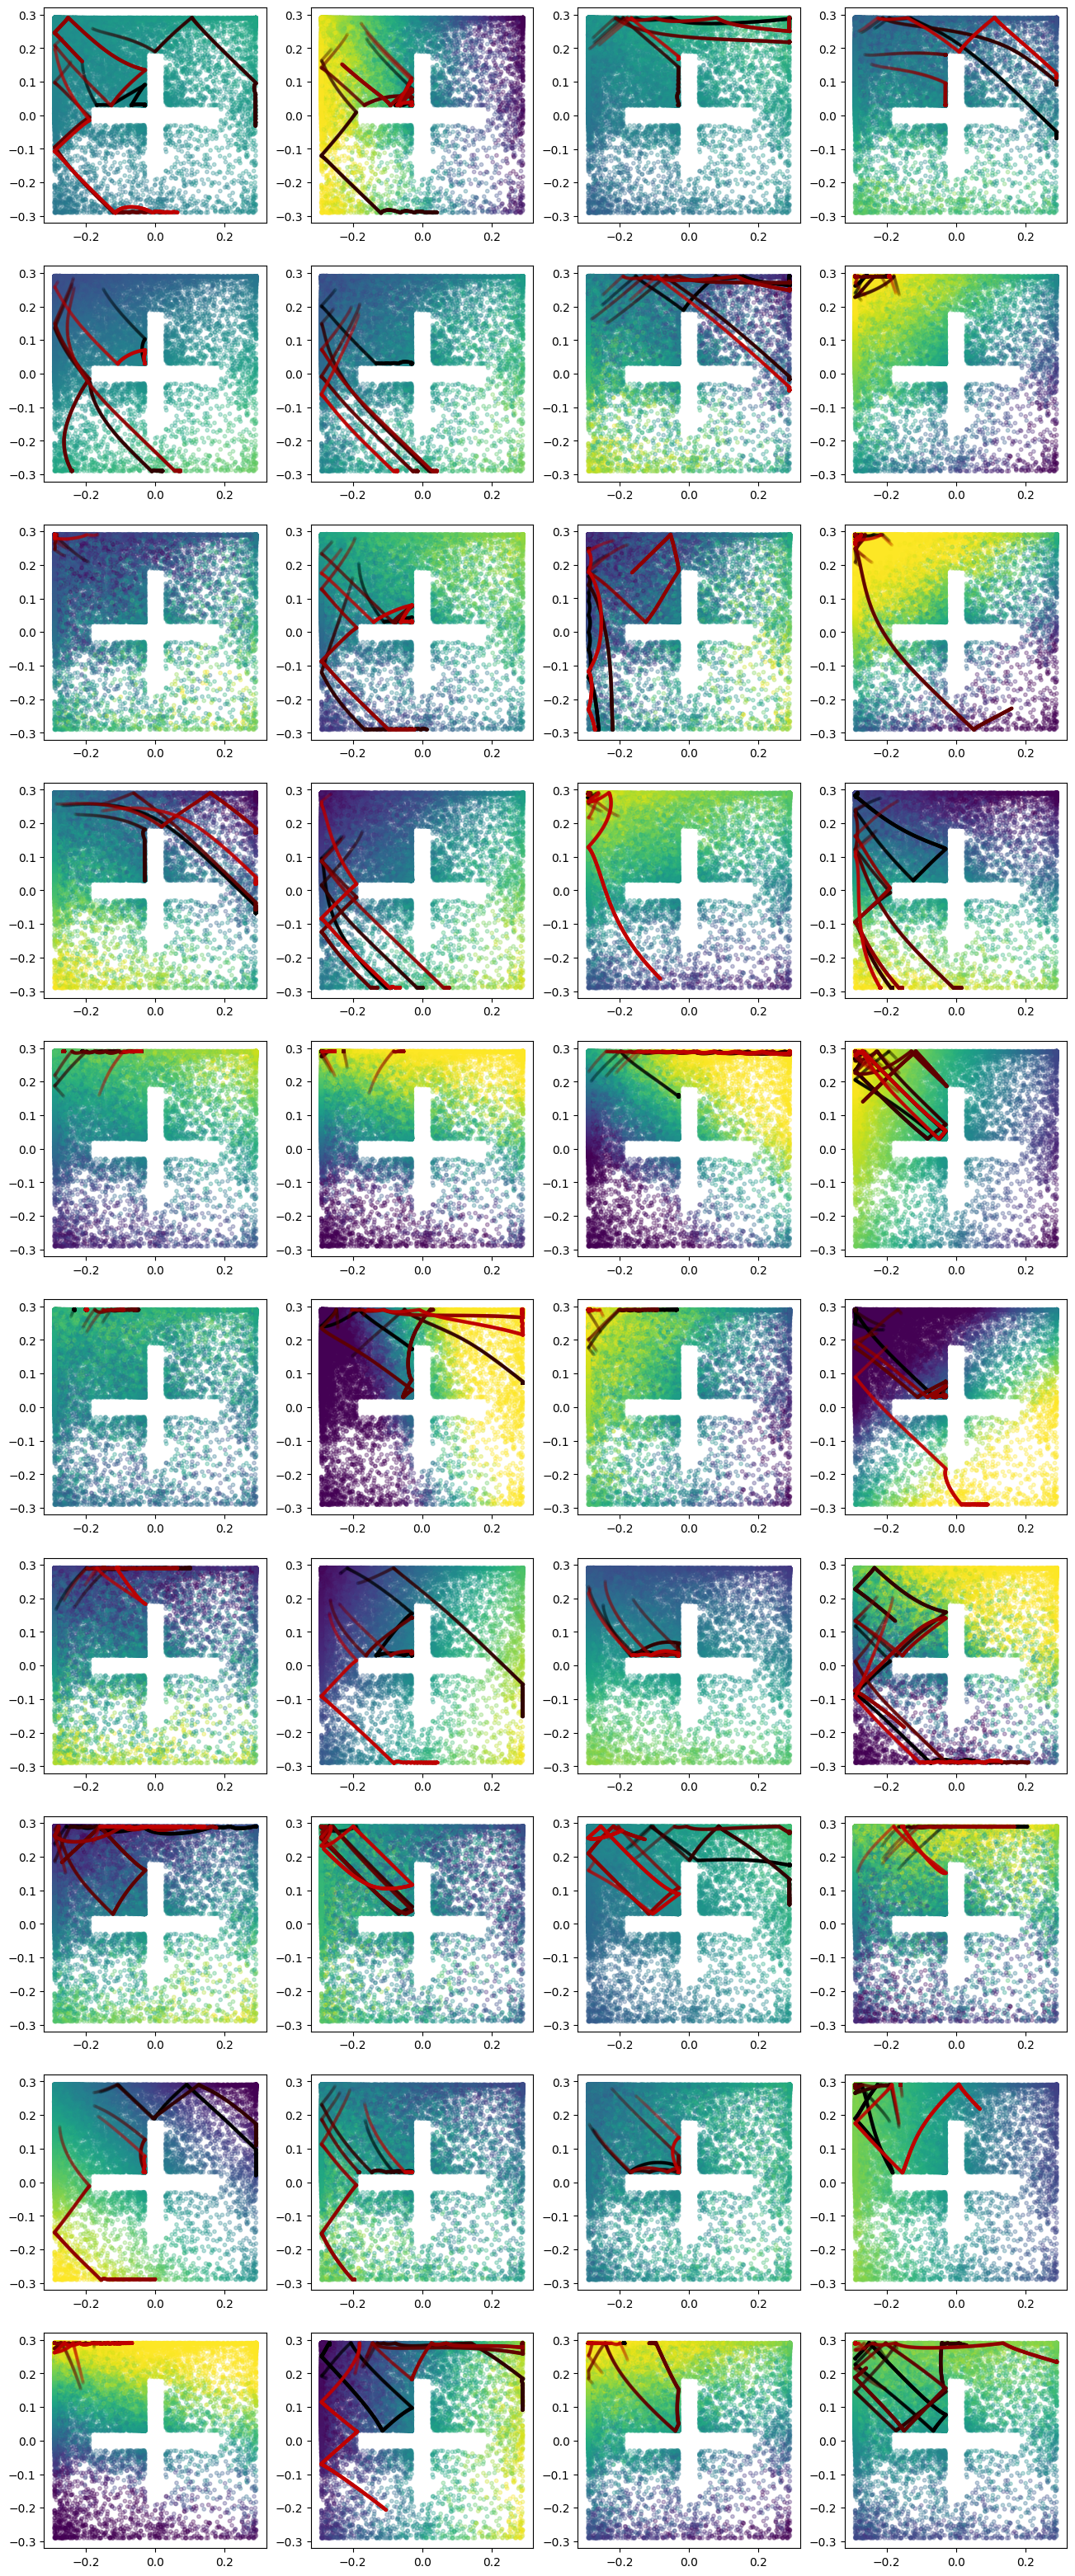

In [48]:
observations_ = dataset.observations
viz_ids = torch.randint(0, observations_.shape[0], (20000,))

nb_test = 40
nb_traj = 5

fig, axs = plt.subplots(int(np.ceil(nb_test/4)), 4, figsize=(4*4, int(np.ceil(nb_test/4))*4))
axs = axs.flatten()

for test_i in tqdm(range(nb_test)):
    
    real_rewards, (eval_param_id, eval_goals) = random_rewards(torch.tensor(observations_[viz_ids]).unsqueeze(0), mlp_p=1)
    encode_obs = torch.tensor(observations_[torch.randint(0, observations_.shape[0], (1*256,))].reshape(1, -1, 4)).to(device)
    encode_rewards, _ = random_rewards(encode_obs, eval_param_id, eval_goals, mlp_p=1)
    encode_rewards = encode_rewards.unsqueeze(-1).to(device)
    reward_state_pairs = torch.concatenate((encode_obs, encode_rewards), axis=-1)
    w_mean, w_log_std = fre_network.get_transformer_encoding(reward_state_pairs)



    trajectories = []
    for _ in range(nb_traj):
        trajectory = []

        state, _ = env.reset()
        trajectory.append(state[0, [0, 1]])

        for _ in range(500):
            
            with torch.no_grad():
                dist = iql_agent.get_actor(w_mean, torch.tensor(state, device=device))
                action = dist.loc.cpu()
                action.clip(-1, 1)
            next_state, reward, done, truncated, info = env.step(action)
            trajectory.append(next_state[0, [0, 1]])
            # break
            
            state = next_state
        
        trajectory = np.stack(trajectory)
        trajectories.append(trajectory)
    
    axs[test_i].scatter(observations_[viz_ids, 0], observations_[viz_ids, 1], c=real_rewards, vmin=-1, vmax=1, s=10, alpha=0.3)
    colors = plt.cm.gist_heat(np.linspace(0, 0.5, nb_traj))
    for i in range(nb_traj):
        axs[test_i].scatter(trajectories[i][:, 0], trajectories[i][:, 1], alpha=np.linspace(0.0, 1, len(trajectory)), c=colors[i], s=5)

In [42]:
action.clip(-1, 1)

tensor([[-0.6059,  0.5029]])